In [2]:
from matplotlib import pyplot as plt
# import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
import tensorflow as tf
import pickle
import json
from preprocessing import inception_preprocessing
from nets import inception

%matplotlib inline

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [3]:
slim = tf.contrib.slim

def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """

    data_provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset, common_queue_capacity=batch_size*3,
    common_queue_min=8)
    
    image_raw, label, bboxes = data_provider.get(['image', 'label', 'bbox'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training, bbox=bboxes)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels, bboxes = tf.train.batch(
          [image, image_raw, label, bboxes],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size,
          dynamic_pad=True)
    
    return images, images_raw, labels, bboxes



In [4]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
""" A kaggle competiton about recognise fishes.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from six.moves import urllib
import tensorflow as tf

from datasets import dataset_utils

slim = tf.contrib.slim

_FILE_PATTERN = 'fish_%s_*.tfrecord'

SPLITS_TO_SIZES = {'train': 11002,
                   'validation': 2750,
                   'test': 1000}

_NUM_CLASSES = 8

_ITEMS_TO_DESCRIPTIONS = {
    'image': 'A color image of varying size.',
    'label': 'The ID of the image',
    'object/bbox': 'A list of bounding boxes.',
    'object/label': 'A list of labels, one per each objec, between 0 and 7',
}


def get_split(split_name, dataset_dir, file_pattern=None, reader=None):
    """Gets a dataset tuple with instructions for reading fish.

    Args:
    split_name: A train/validation split name.
    dataset_dir: The base directory of the dataset sources.
    file_pattern: The file pattern to use when matching the dataset sources.
      It is assumed that the pattern contains a '%s' string so that the split
      name can be inserted.
    reader: The TensorFlow reader type.

    Returns:
    A `Dataset` namedtuple.

    Raises:
    ValueError: if `split_name` is not a valid train/validation split.
    """
    if split_name not in SPLITS_TO_SIZES:
        raise ValueError('split name %s was not recognized.' % split_name)

    if not file_pattern:
        file_pattern = _FILE_PATTERN
        file_pattern = os.path.join(dataset_dir, file_pattern % split_name)

    # Allowing None in the signature so that dataset_factory can use the default.
    if reader is None:
        reader = tf.TFRecordReader

    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
        'image/height': tf.FixedLenFeature([], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
        'image/width': tf.FixedLenFeature([], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
        'image/class/label': tf.FixedLenFeature([], tf.string, default_value='no name'),
        'image/object/bbox/ymin': tf.VarLenFeature(tf.float32),
        'image/object/bbox/xmin': tf.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.VarLenFeature(tf.float32),
        'image/object/class/label': tf.VarLenFeature(tf.int64),
    }

    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(),
        'height': slim.tfexample_decoder.Tensor('image/height'),
        'width': slim.tfexample_decoder.Tensor('image/width'),
        'name': slim.tfexample_decoder.Tensor('image/class/label'),
        'object/bbox': slim.tfexample_decoder.BoundingBox(
            ['ymin', 'xmin', 'ymax', 'xmax'], 'image/object/bbox/'),
        'object/label': slim.tfexample_decoder.Tensor('image/object/class/label'),
    }

    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)

    labels_to_names = None
    if dataset_utils.has_labels(dataset_dir):
        labels_to_names = dataset_utils.read_label_file(dataset_dir)

    return slim.dataset.Dataset(
        data_sources=file_pattern,
        reader=reader,
        decoder=decoder,
        num_samples=SPLITS_TO_SIZES[split_name],
        items_to_descriptions=_ITEMS_TO_DESCRIPTIONS,
        num_classes=_NUM_CLASSES,
        labels_to_names=labels_to_names)


In [ ]:
# convnet visualize


slim = tf.contrib.slim

# image_size = inception.inception_v3.default_image_size
# image_size-Mixed_7c : 512-14
# image_size-Mixed_7b : 512-14
# image_size-Mixed_6e : 512-30
# image_size-Mixed_5d : 512-61
image_size = 720
batch_size = 8
fish_data_dir = 'tmp/fish/dataset'
train_dir = 'tmp/fish/inception_finetuned/'


with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('validation', fish_data_dir)
    images, images_raw, labels, bboxes = load_batch(dataset, height=image_size, width=image_size, batch_size=batch_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, _end_points = inception.inception_v3_base(images)
#          _, _convnet = inception.inception_v3_base(images)
            
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_end_points, np_images_raw, np_bboxes = sess.run([_end_points, images_raw, bboxes])
            plt.rcParams['figure.figsize'] = (30.0, 15.0)
#             for i in range(batch_size): 
#                 image = np_images_raw[i, :, :, :]
#                 convnet = np_end_points['Mixed_5d'][i]
#                 vis_square(convnet.transpose(2, 0, 1), padval=0.5)
                
#                 plt.figure()
#                 plt.imshow(image.astype(np.uint8))
#                 plt.axis('off')
#                 plt.show()
                

In [ ]:
# Note that this may take several minutes!!
# Fine-tune pre-trained netoworks.

import os

from nets import inception
from preprocessing import inception_preprocessing

slim = tf.contrib.slim
image_size = inception.inception_v3.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
    
    return slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
        variables_to_restore)


train_dir = 'tmp/fish/inception_ssd/'
fish_data_dir = 'tmp/fish/dataset'
checkpoints_dir = 'tmp/fish/my_checkpoints'
batch_size = 16
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('train', fish_data_dir)
    
    images, _, labels, bboxes = load_batch(dataset, height=image_size, width=image_size, batch_size=batch_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, _end_points = inception.inception_v3_base(images)
        
#     # Specify the loss function:
#     with tf.device('/cpu:0'):
#         one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
#     slim.losses.softmax_cross_entropy(logits, one_hot_labels)
#     total_loss = slim.losses.get_total_loss()

    # image_size - Mixed_7c : 720 - 21x21x2048
    # image_size - Mixed_7b : 720 - 21x21x2048
    # image_size - Mixed_6e : 720 - 43x43x768
    # image_size - Mixed_5d : 720 - 87x87x228
    
#     Mixed_5d = _end_points['Mixed_5d']
    
    num_default_bbox=5
    output_pre_class = (dataset.num_classes+4)*num_default_bbox
    
    Mixed_6e = _end_points['Mixed_6e']
    Mixed_6e_ssd = slim.conv2d(Mixed_6e, output_pre_class, [3 ,3] )
    
    Mixed_7b = _end_points['Mixed_7b']
    Mixed_7b_ssd = slim.conv2d(Mixed_7b, 1024, [3, 3])
    Mixed_7b_ssd = slim.conv2d(Mixed_7b_ssd, output_pre_class, [3 ,3] )

    #21
    Mixed_7c = _end_points['Mixed_7c']
    Mixed_7c_ssd = slim.conv2d(Mixed_7c, 1024, [1, 1])
    Mixed_7c_ssd = slim.conv2d(Mixed_6e, output_pre_class, [3 ,3] )
    
    #11
    Conv_8a_ssd = slim.conv2d(Mixed_7c_ssd, 256, [1, 1])
    Conv_8b_ssd = slim.conv2d(Conv_8a_ssd, 512, [3, 3], stride=2)

    #6
    Conv_9a_ssd = slim.conv2d(Conv_8b_ssd, 128, [1, 1])
    Conv_9b_ssd = slim.conv2d(Conv_9a_ssd, 256, [3, 3], stride=2)

    #3
    Conv_10a_ssd = slim.conv2d(Conv_9b_ssd, 128, [1, 1])
    Conv_10b_ssd = slim.conv2d(Conv_10a_ssd, 256, [3, 3], stride=2)
    
    #1
    pool_11_ssd = slim.pool(Conv_10b_ssd, [3, 3], pooling_type="AVG")




    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    # GPU error on incepton-v3 because of motherboard: "failed to query event: CUDA_ERROR_LAUNCH_FAILED,Unexpected Event status: 1"

#     config = tf.ConfigProto(device_count = {'gpu': 0})
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

# windows 查看tensorflow/contrib/slim/python/slim/learning.py 中的 start_standard_services = False
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=5,
        session_config=config,)
        
print('Finished training. Last batch loss %f' % final_loss)

In [5]:
slim = tf.contrib.slim

def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """

    data_provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset, common_queue_capacity=batch_size*3,
    common_queue_min=8)
    
    image_raw, label, bboxes, name = data_provider.get(['image', 'object/label', 'object/bbox', 'name'])
    
    # Preprocess image for usage by Inception.
    image, distorted_bbox = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=True)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels, bboxes, distorted_bbox, name = tf.train.batch(
          [image, image_raw, label, bboxes, distorted_bbox, name],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size,
          dynamic_pad=True)
    
    return images, images_raw, labels, bboxes, distorted_bbox, name


In [20]:
#load dataset|
slim = tf.contrib.slim

image_size = 720
batch_size = 8
fish_data_dir = 'tmp/fish/dataset'


with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_split('validation', fish_data_dir)
    images, images_raw, labels, bboxes, distorted_bbox, name = load_batch(dataset, height=image_size, width=image_size, batch_size=batch_size)
    
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            np_images, np_images_raw, np_bboxes, np_distorted_bbox, labels, name = sess.run([images, images_raw, bboxes, distorted_bbox, labels, name])
                

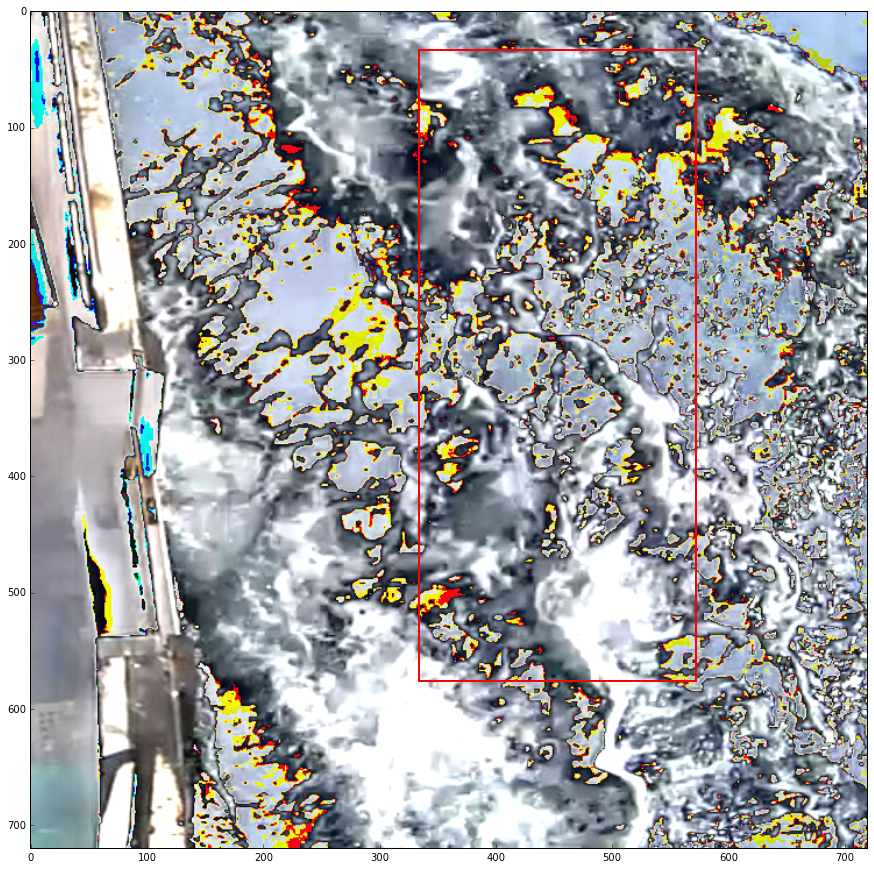

In [44]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.rcParams['figure.figsize'] = (30.0, 15.0)
ind = 1
plt.figure()
# plt.imshow(np_images_raw[ind].astype(np.uint8))
plt.imshow(np_images[ind])
width = 720
height = 720
currentAxis = plt.gca()
j = 0
for rect in np_distorted_bbox[ind]:
    [ymin, xmin, ymax, xmax] = rect[-1]
    coords = (xmin*width, ymin*height), (xmax-xmin)*width, (ymax-ymin)*height
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[j], linewidth=2))
    j += 1

In [ ]:
def bboxes_jaccard(bbox_ref, bboxes, name=None):
    """Compute jaccard score between a reference box and a collection
    of bounding boxes.

    Args:
      bbox_ref: (N, 4) or (4,) Tensor with reference bounding box(es).
      bboxes: (N, 4) Tensor, collection of bounding boxes.
    Return:
      (N,) Tensor with Jaccard scores.
    """
    with tf.name_scope(name, 'bboxes_jaccard'):
        # Should be more efficient to first transpose.
        bboxes = tf.transpose(bboxes)
        bbox_ref = tf.transpose(bbox_ref)
        # Intersection bbox and volume.
        int_ymin = tf.maximum(bboxes[0], bbox_ref[0])
        int_xmin = tf.maximum(bboxes[1], bbox_ref[1])
        int_ymax = tf.minimum(bboxes[2], bbox_ref[2])
        int_xmax = tf.minimum(bboxes[3], bbox_ref[3])
        h = tf.maximum(int_ymax - int_ymin, 0.)
        w = tf.maximum(int_xmax - int_xmin, 0.)
        # Volumes.
        inter_vol = h * w
        union_vol = -inter_vol \
            + (bboxes[2] - bboxes[0]) * (bboxes[3] - bboxes[1]) \
            + (bbox_ref[2] - bbox_ref[0]) * (bbox_ref[3] - bbox_ref[1])
        jaccard = tfe_math.safe_divide(inter_vol, union_vol, 'jaccard')
        return jaccard
    
def bboxes_resize(bbox_ref, bboxes, name=None):
    """Resize bounding boxes based on a reference bounding box,
    assuming that the latter is [0, 0, 1, 1] after transform. Useful for
    updating a collection of boxes after cropping an image.
    """
    with tf.name_scope(name, 'bboxes_resize'):
        # Translate.
        v = tf.stack([bbox_ref[0], bbox_ref[1], bbox_ref[0], bbox_ref[1]])
        bboxes = bboxes - v
        # Scale.
        s = tf.stack([bbox_ref[2] - bbox_ref[0],
                      bbox_ref[3] - bbox_ref[1],
                      bbox_ref[2] - bbox_ref[0],
                      bbox_ref[3] - bbox_ref[1]])
        bboxes = bboxes / s
        return bboxes

In [ ]:
# np version bbox preprocess
def bboxes_resize(bbox_ref, bboxes, name=None):
    """Resize bounding boxes based on a reference bounding box,
    assuming that the latter is [0, 0, 1, 1] after transform. Useful for
    updating a collection of boxes after cropping an image.
    """

    bbox_ref = np_distorted_bbox.reshape(-1, 4)
    v = np.column_stack([bbox_ref[:, 0], bbox_ref[:, 1], bbox_ref[:, 0], bbox_ref[:, 1]]).reshape(-1 ,1, 4) 
    bboxes = bboxes - v
    # Scale.
    s = np.stack([bbox_ref[:, 2] - bbox_ref[:, 0],
                  bbox_ref[:, 3] - bbox_ref[:, 1],
                  bbox_ref[:, 2] - bbox_ref[:, 0],
                  bbox_ref[:, 3] - bbox_ref[:, 1]]).reshape(-1, 1, 4)
    bboxes = bboxes / s
    bboxes = np.minimum(np.maximum(bboxes, 0), 1)
    return bboxes

def bboxes_jaccard(bbox_ref, bboxes, name=None):
    """Compute jaccard score between a reference box and a collection
    of bounding boxes.

    Args:
      bbox_ref: (N, 4) or (4,) Tensor with reference bounding box(es).
      bboxes: (N, 4) Tensor, collection of bounding boxes.
    Return:
      (N,) Tensor with Jaccard scores.
    """

    # Should be more efficient to first transpose.
    bboxes = np.transpose(bboxes)
    bbox_ref = np.transpose(bbox_ref)
    # Intersection bbox and volume.
    int_ymin = tf.maximum(bboxes[0], bbox_ref[0])
    int_xmin = tf.maximum(bboxes[1], bbox_ref[1])
    int_ymax = tf.minimum(bboxes[2], bbox_ref[2])
    int_xmax = tf.minimum(bboxes[3], bbox_ref[3])
    h = tf.maximum(int_ymax - int_ymin, 0.)
    w = tf.maximum(int_xmax - int_xmin, 0.)
    # Volumes.
    inter_vol = h * w
    union_vol = -inter_vol \
        + (bboxes[2] - bboxes[0]) * (bboxes[3] - bboxes[1]) \
        + (bbox_ref[2] - bbox_ref[0]) * (bbox_ref[3] - bbox_ref[1])
    jaccard = tfe_math.safe_divide(inter_vol, union_vol, 'jaccard')
    return jaccard

In [ ]:
bboxes = bboxes_resize(np_distorted_bbox, np_bboxes)

In [ ]:
bboxes.shape

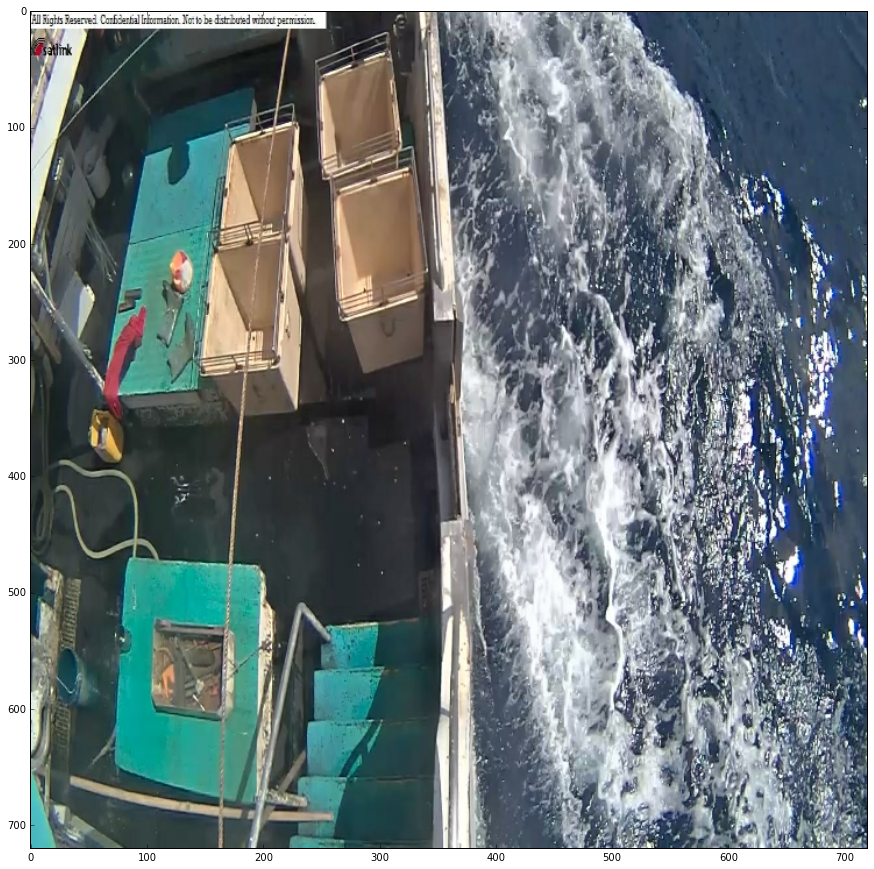

In [42]:
plt.imshow(np_images_raw[1].astype(np.uint8))

In [47]:
np_bboxes

array([[[ 0.05979579,  0.29299939,  0.25367913,  0.43949908],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.73100615,  0.78828126,  0.85318273,  0.99609375],
        [ 0.00289528,  0.27208593,  0.12594455,  0.42960939]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.38970834,  0.54637498,  0.51895833,  0.61246878],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.20133333,  0.33750001,  0.44933334,  0.50312501],
        [ 0.        ,  0.        ,  0.        ,  0.     